**Run the demo.** Run the following cells to compute semantic correspondences for real image pairs.

In [1]:
%load_ext autoreload
%autoreload 2
from archs.stable_diffusion.diffusion import latent_to_image
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import (
  process_image,
  rescale_points,
  draw_correspondences,
  compute_pck,
  find_nn_source_correspondences,
  find_best_buddies_correspondences,
  find_cyclical_correspondences,
)
import os
import random
import torch

import einops
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import json
import torchvision

from extract_hyperfeatures import load_models

In [2]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "configs/real.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


c:\Users\saqib\miniconda3\envs\pytorch_env\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [3]:
def load_image_pair(ann, load_size, device, image_path=""):
  img1_pil = Image.open(f"{image_path}/{ann['source_path']}").convert("RGB")
  img2_pil = Image.open(f"{image_path}/{ann['target_path']}").convert("RGB")
  source_size = img1_pil.size
  target_size = img2_pil.size

  # swap from (x, y) to (y, x)
  if "source_points" in ann:
    source_points, target_points = ann["source_points"], ann["target_points"]
    source_points = np.flip(source_points, 1)
    target_points = np.flip(target_points, 1)
    source_points = rescale_points(source_points, source_size, load_size)
    target_points = rescale_points(target_points, target_size, load_size)
  else:
    source_points, target_points = None, None

  img1, img1_pil = process_image(img1_pil, res=load_size)
  img2, img2_pil = process_image(img2_pil, res=load_size)
  img1, img2 = img1.to(device), img2.to(device)
  imgs = torch.cat([img1, img2])
  
  return source_points, target_points, img1_pil, img2_pil, imgs

def load_saliency_pair(ann, output_size, device, saliency_path=""):
  def _load_saliency(path):
    if os.path.exists(path):
      saliency_pil = Image.open(path).convert("L")
      saliency_map, _ = process_image(saliency_pil, res=output_size, range=(0, 1))
      saliency_map = einops.rearrange(saliency_map, 'b c h w -> (b c) (h w)')
    else:
      saliency_map = torch.ones((1, output_size[0] * output_size[1]))
    saliency_map = saliency_map.to(device)
    return saliency_map
  saliency_map1 = _load_saliency(f"{saliency_path}/{ann['source_path']}")
  saliency_map2 = _load_saliency(f"{saliency_path}/{ann['target_path']}")
  return saliency_map1, saliency_map2

def reshape_descriptors(img1_feats, img2_feats):
  b, d, w, h = img1_feats.shape
  descriptors1 = img1_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  descriptors2 = img2_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  return descriptors1, descriptors2

def postprocess_points(source_points, predicted_points, output_size, load_size):
  source_points = source_points.detach().cpu().numpy()
  predicted_points = predicted_points.detach().cpu().numpy()
  source_points = rescale_points(source_points, output_size, load_size)
  predicted_points = rescale_points(predicted_points, output_size, load_size)
  return source_points, predicted_points

**Compute semantic keypoint matches.** Use one of the correspondence functions:
- `nearest_neighbors`: For a set of annotated source_points, compute the nearest neighbor predicted_points.
- `best_buddies`: Compute the top-k pairs of source_points, predicted_points using the [best buddies algorithm](https://github.com/ShirAmir/dino-vit-features) (Amir et. al., ECCVW 2022).

In [4]:
image_path = "assets/spair/images"
saliency_path = "assets/spair/odise"
annotation_path = "annotations/spair_71k_test-6.json"
load_size = (224, 224)
output_size = (config["output_resolution"], config["output_resolution"])

# Select from [nearest_neighbors, best_buddies]
correspondence_function = "nearest_neighbors"
# Number of correspondences to display when using [best_buddies]
num_pairs = 10

source_points: [[171.584        1.792     ]
 [168.896       85.41866667]
 [177.408       40.02133333]
 [210.56        89.00266667]]
predicted_points: [[176.512       86.61333333]
 [176.96       117.07733333]
 [177.856      102.74133333]
 [184.576      114.09066667]]


d:\3D Computer Vision\diffusion_hyperfeatures-main\archs\aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


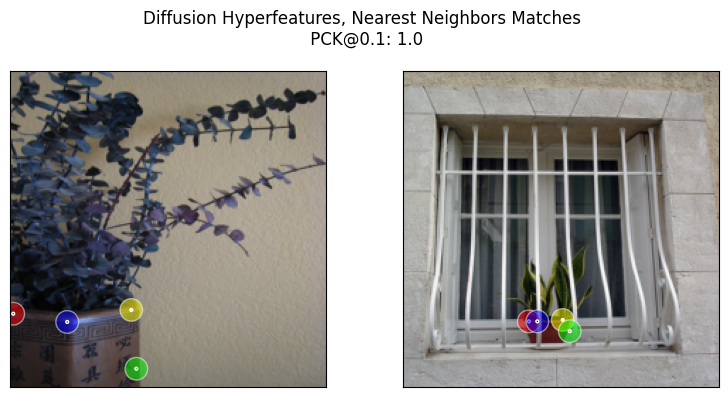

source_points: [[ 50.176       54.35733333]
 [ 67.2        112.29866667]
 [150.976      114.688     ]
 [ 90.496       54.35733333]
 [ 94.976       29.26933333]
 [118.272      130.816     ]
 [154.112       91.392     ]]
predicted_points: [[122.54117647 109.76      ]
 [125.17647059 133.504     ]
 [173.27058824 139.776     ]
 [175.24705882  68.544     ]
 [181.83529412  56.896     ]
 [148.89411765 146.944     ]
 [177.88235294 121.856     ]]


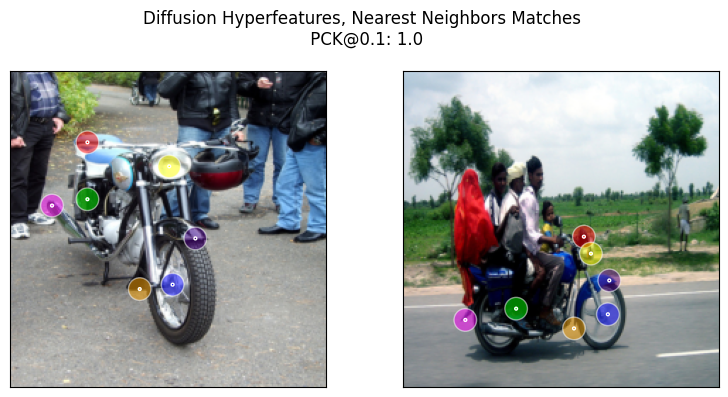

source_points: [[ 74.66666667  81.536     ]
 [ 84.82133333  87.808     ]
 [ 62.72        89.152     ]
 [ 89.6         87.808     ]
 [150.528       99.456     ]
 [162.47466667 104.384     ]
 [145.74933333 143.808     ]
 [151.72266667 153.664     ]
 [ 89.00266667 157.696     ]]
predicted_points: [[ 61.39759036 162.624     ]
 [ 68.81927711 171.136     ]
 [ 51.27710843 168.        ]
 [ 73.54216867 171.136     ]
 [172.04819277 138.88      ]
 [163.95180723 169.344     ]
 [178.79518072  79.296     ]
 [172.72289157  98.112     ]
 [ 88.38554217  94.08      ]]


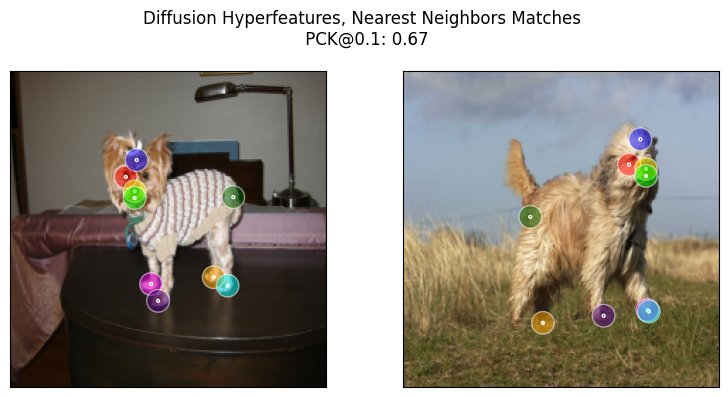

source_points: [[206.976       41.70570571]
 [139.328       67.26726727]
 [123.2         70.63063063]
 [ 79.744       63.23123123]
 [ 93.184      129.15315315]
 [ 83.776      158.07807808]
 [ 12.096      174.89489489]]
predicted_points: [[120.71856287 215.04      ]
 [103.28143713 201.6       ]
 [ 97.24550898 186.816     ]
 [ 98.58682635  12.544     ]
 [107.9760479   37.184     ]
 [ 98.58682635  48.384     ]
 [ 50.2994012   16.576     ]]


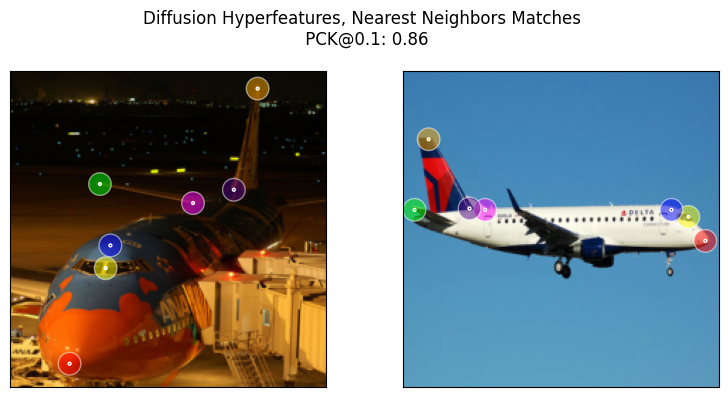

source_points: [[152.32       107.52      ]
 [157.09866667 115.584     ]
 [188.75733333 112.896     ]
 [210.26133333  56.896     ]
 [191.744       73.472     ]
 [182.18666667  11.2       ]
 [180.39466667  51.52      ]]
predicted_points: [[ 94.08        68.14457831]
 [103.04        93.10843373]
 [128.128      108.62650602]
 [174.272       93.10843373]
 [180.544      105.25301205]
 [175.168       82.31325301]
 [154.56        81.63855422]]


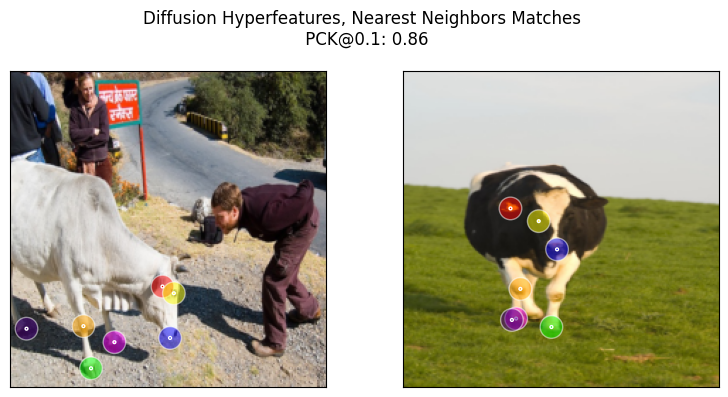

source_points: [[ 84.91940299 150.528     ]
 [111.66567164 153.664     ]
 [114.34029851 153.216     ]
 [ 90.26865672 146.048     ]
 [189.22985075 142.464     ]
 [177.86268657 129.024     ]
 [116.34626866  90.496     ]
 [165.82686567 132.608     ]
 [161.14626866 139.776     ]]
predicted_points: [[ 88.79279279 118.272     ]
 [109.64564565 124.992     ]
 [110.31831832 124.096     ]
 [ 90.81081081 119.616     ]
 [144.62462462  96.32      ]
 [143.27927928 117.824     ]
 [104.26426426  72.576     ]
 [133.86186186  97.664     ]
 [133.86186186 112.        ]]


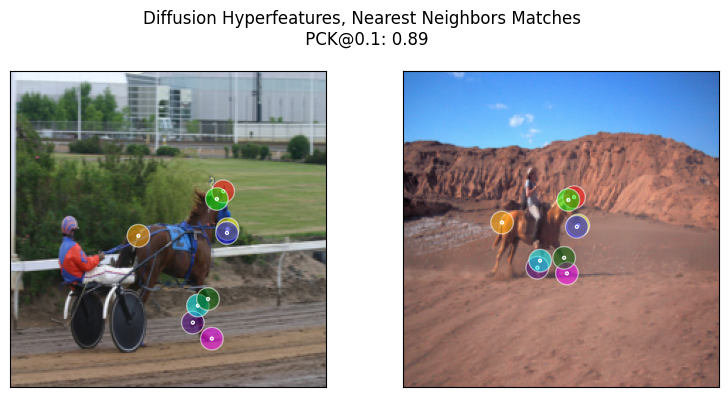

In [6]:
for ann in json.load(open(annotation_path)):
  source_points, target_points, img1_pil, img2_pil, imgs = load_image_pair(ann, load_size, device, image_path)
  print("source_points:", source_points)
  print("predicted_points:", target_points)
  
  with torch.inference_mode():
    with torch.autocast("cuda"):
      feats, _ = diffusion_extractor.forward(imgs)
      b, s, l, w, h = feats.shape
      diffusion_hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
      img1_hyperfeats = diffusion_hyperfeats[0][None, ...]
      img2_hyperfeats = diffusion_hyperfeats[1][None, ...]

  if correspondence_function == "nearest_neighbors":
    _, predicted_points = find_nn_source_correspondences(img1_hyperfeats, img2_hyperfeats, source_points, output_size, load_size)
    predicted_points = predicted_points.detach().cpu().numpy()
    distances, _, pck_metric = compute_pck(predicted_points, target_points, load_size)
    title = f"Diffusion Hyperfeatures, Nearest Neighbors Matches \n PCK@0.1: {pck_metric.round(decimals=2)}"
  elif correspondence_function == "best_buddies":
    descriptors1, descriptors2 = reshape_descriptors(img1_hyperfeats, img2_hyperfeats)
    saliency_map1, saliency_map2 = load_saliency_pair(ann, output_size, img1_hyperfeats.device, saliency_path)
    source_points, predicted_points = find_best_buddies_correspondences(descriptors1, descriptors2, saliency_map1, saliency_map2, num_pairs=num_pairs)
    source_points, predicted_points = postprocess_points(source_points, predicted_points, output_size, load_size)
    title = "Diffusion Hyperfeatures, Best Buddies Matches"
  else:
    raise NotImplementedError
  
  draw_correspondences(source_points, predicted_points, img1_pil, img2_pil, title=title)
  plt.show()